In [1]:
import warnings
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve, LearningCurveDisplay
from sklearn.metrics import make_scorer, root_mean_squared_error

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from xgboost import XGBRegressor

from utils.trainer import Trainer, ARIMATrainer
from utils.tuner import ARIMATuner, XGBTuner
from utils.pairs import PairsFinder
from utils.trader import AutoTrader

## **Exploratory Analysis**

Selected pairs: [('AAPL', 'LNVGY'), ('AMD', 'DELL'), ('AMD', 'LNVGY'), ('AMD', 'MSFT'), ('DELL', 'MSFT')]


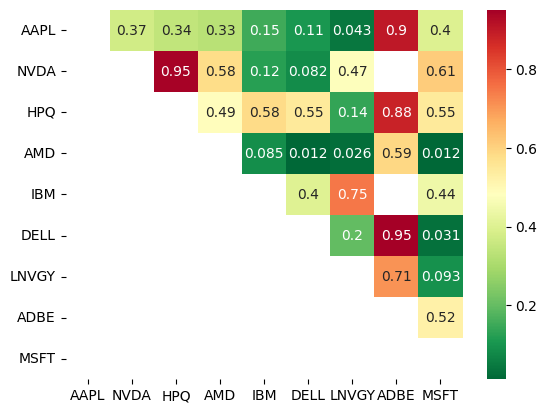

In [2]:
stocks = ['AAPL', 'NVDA', 'HPQ', 
          'AMD', 'IBM', 'DELL', 
          'LNVGY', 'ADBE', 'MSFT']

pairs_finder = PairsFinder()

pairs = pairs_finder.plot_coint_heatmap(stocks)

print(f'Selected pairs: {pairs}')


Hedge Ratio: 1.0


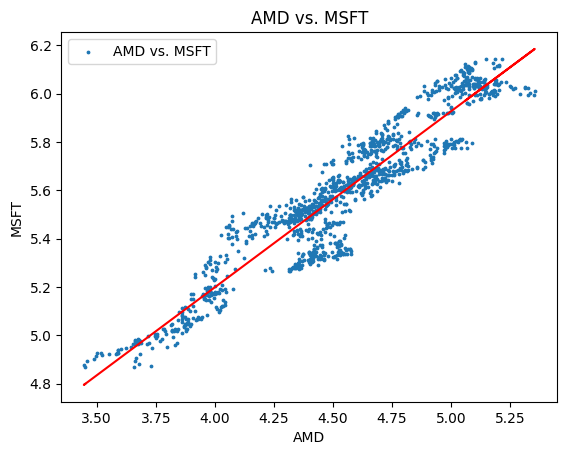

In [3]:
pair = ('AMD', 'MSFT')

pairs_finder.plot_hedge_ratio(pair)

_, hedge_ratio = pairs_finder.get_hedge_ratio(pair)

print(f'Hedge Ratio: {hedge_ratio}')

plt.title(pair[0] + ' vs. ' + pair[1]) 

plt.show()

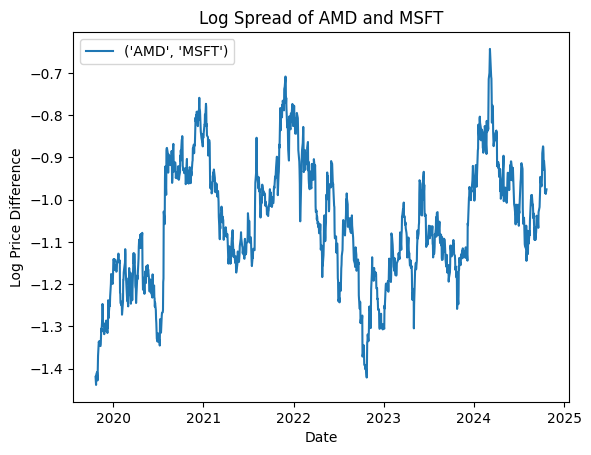

In [4]:
pairs_finder.plot_spread(pair)
plt.title('Log Spread of ' + pair[0] +  ' and ' + pair[1])
plt.show()

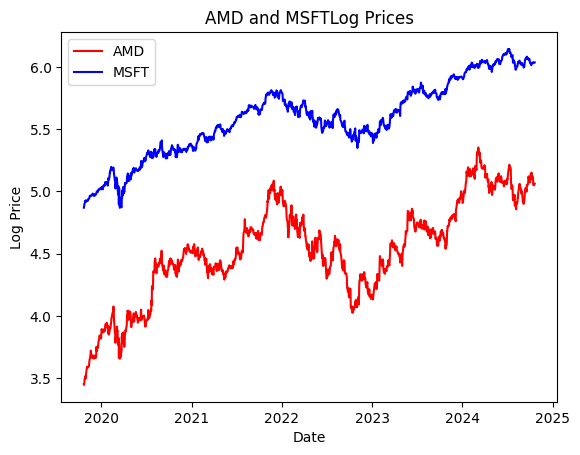

In [5]:
amd = np.log(yf.Ticker(pair[0]).history(period='5y')['Close'])
dell = np.log(yf.Ticker(pair[1]).history(period='5y')['Close'])

plt.plot(amd.index, amd, label=pair[0], color='red')
plt.plot(dell.index, dell, label=pair[1], color='blue')

plt.title(pair[0] + ' and ' + pair[1] + 'Log Prices')
plt.xlabel('Date')
plt.ylabel('Log Price')

plt.legend()

plt.show()

p-value of ADF test: 0.01751793917699875
The time series is stationary


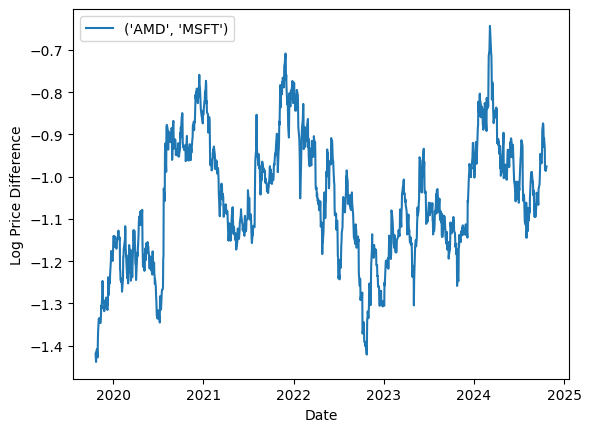

In [6]:
pairs_finder.plot_spread(pair)

spread = pairs_finder.get_spread(pair)

spread_train, spread_test = train_test_split(
    spread,
    test_size=0.2,
    train_size=0.8,
    shuffle=False
)

trainer = Trainer()

_ = trainer.is_stationary(spread_train)

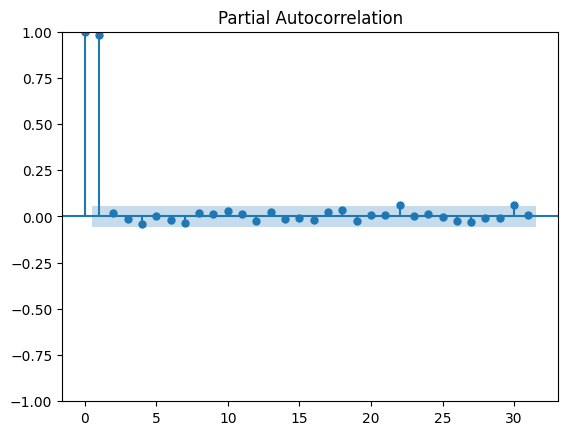

In [7]:
plot_pacf(spread)

plt.show()

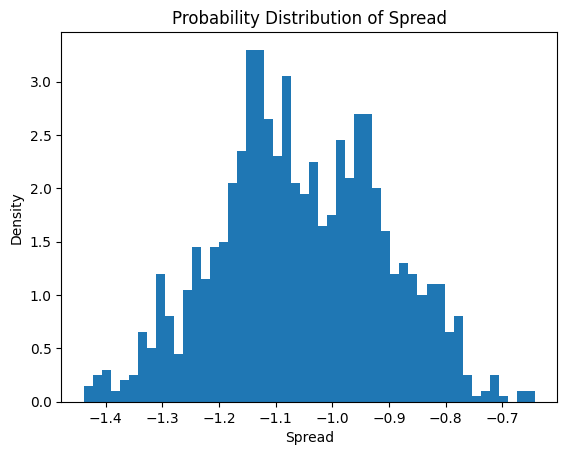

In [8]:
spread_list = spread.reset_index()['Close'].to_list()


spread_list.sort()

plt.hist(spread_list, bins=50, density=True)

plt.title('Probability Distribution of Spread')

plt.xlabel('Spread')
plt.ylabel('Density')

plt.show()

## **XGBoost Model**

In [9]:
lags = range(1, 6)
spread_df = trainer.generate_out_of_sample_features(spread, lags)
spread_df = trainer.generate_features(spread_df)

x = spread_df.drop('Close', axis=1)
y = spread_df['Close']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, train_size=0.8, shuffle=False)

/home/jujubee/msc/sem-2-2024/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [23]:
xgb_optimiser = XGBTuner().bayesian_optimisation(x_train, y_train)

print(xgb_optimiser.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START learning_rate=0.7553178175861669, max_depth=9, n_estimators=387, subsample=0.9804191644365203
[CV 1/5; 1/1] END learning_rate=0.7553178175861669, max_depth=9, n_estimators=387, subsample=0.9804191644365203;, score=-5.612 total time=   0.2s
[CV 2/5; 1/1] START learning_rate=0.7553178175861669, max_depth=9, n_estimators=387, subsample=0.9804191644365203
[CV 2/5; 1/1] END learning_rate=0.7553178175861669, max_depth=9, n_estimators=387, subsample=0.9804191644365203;, score=-1.392 total time=   0.3s
[CV 3/5; 1/1] START learning_rate=0.7553178175861669, max_depth=9, n_estimators=387, subsample=0.9804191644365203
[CV 3/5; 1/1] END learning_rate=0.7553178175861669, max_depth=9, n_estimators=387, subsample=0.9804191644365203;, score=-1.814 total time=   0.3s
[CV 4/5; 1/1] START learning_rate=0.7553178175861669, max_depth=9, n_estimators=387, subsample=0.9804191644365203
[CV 4/5; 1/1] END learning_rate=0.7553178175861

/home/jujubee/msc/sem-2-2024/.venv/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.01, 3, 100, 0.5] before, using random point [0.11402070864552695, 7, 256, 0.960324512225402]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START learning_rate=0.11402070864552695, max_depth=7, n_estimators=256, subsample=0.960324512225402
[CV 1/5; 1/1] END learning_rate=0.11402070864552695, max_depth=7, n_estimators=256, subsample=0.960324512225402;, score=-4.980 total time=   1.1s
[CV 2/5; 1/1] START learning_rate=0.11402070864552695, max_depth=7, n_estimators=256, subsample=0.960324512225402
[CV 2/5; 1/1] END learning_rate=0.11402070864552695, max_depth=7, n_estimators=256, subsample=0.960324512225402;, score=-0.926 total time=   1.2s
[CV 3/5; 1/1] START learning_rate=0.11402070864552695, max_depth=7, n_estimators=256, subsample=0.960324512225402
[CV 3/5; 1/1] END learning_rate=0.11402070864552695, max_depth=7, n_estimators=256, subsample=0.960324512225402;, score=-1.270 total time=   1.0s
[CV 4/5; 1/1] START learning_rate=0.11402070864552695, max_depth=7, n_estimators=256, subsample=0.960324512225402
[CV 4/5; 1/1] END learning_rate=0.1140207086455

/home/jujubee/msc/sem-2-2024/.venv/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.01, 3, 100, 0.5] before, using random point [0.04838954139598633, 11, 958, 0.8815754597810745]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START learning_rate=0.04838954139598633, max_depth=11, n_estimators=958, subsample=0.8815754597810745
[CV 1/5; 1/1] END learning_rate=0.04838954139598633, max_depth=11, n_estimators=958, subsample=0.8815754597810745;, score=-4.977 total time=   1.8s
[CV 2/5; 1/1] START learning_rate=0.04838954139598633, max_depth=11, n_estimators=958, subsample=0.8815754597810745
[CV 2/5; 1/1] END learning_rate=0.04838954139598633, max_depth=11, n_estimators=958, subsample=0.8815754597810745;, score=-1.120 total time=   2.7s
[CV 3/5; 1/1] START learning_rate=0.04838954139598633, max_depth=11, n_estimators=958, subsample=0.8815754597810745
[CV 3/5; 1/1] END learning_rate=0.04838954139598633, max_depth=11, n_estimators=958, subsample=0.8815754597810745;, score=-1.247 total time=   3.0s
[CV 4/5; 1/1] START learning_rate=0.04838954139598633, max_depth=11, n_estimators=958, subsample=0.8815754597810745
[CV 4/5; 1/1] END learning_rate=0

/home/jujubee/msc/sem-2-2024/.venv/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.01, 3, 100, 0.5] before, using random point [0.6880812660221826, 3, 522, 0.6459407957411248]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START learning_rate=0.6880812660221826, max_depth=3, n_estimators=522, subsample=0.6459407957411248
[CV 1/5; 1/1] END learning_rate=0.6880812660221826, max_depth=3, n_estimators=522, subsample=0.6459407957411248;, score=-5.572 total time=   0.3s
[CV 2/5; 1/1] START learning_rate=0.6880812660221826, max_depth=3, n_estimators=522, subsample=0.6459407957411248
[CV 2/5; 1/1] END learning_rate=0.6880812660221826, max_depth=3, n_estimators=522, subsample=0.6459407957411248;, score=-1.581 total time=   0.7s
[CV 3/5; 1/1] START learning_rate=0.6880812660221826, max_depth=3, n_estimators=522, subsample=0.6459407957411248
[CV 3/5; 1/1] END learning_rate=0.6880812660221826, max_depth=3, n_estimators=522, subsample=0.6459407957411248;, score=-1.204 total time=   0.3s
[CV 4/5; 1/1] START learning_rate=0.6880812660221826, max_depth=3, n_estimators=522, subsample=0.6459407957411248
[CV 4/5; 1/1] END learning_rate=0.6880812660221

/home/jujubee/msc/sem-2-2024/.venv/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.01, 3, 100, 0.5] before, using random point [0.9753066523470723, 11, 805, 0.9027574307849318]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START learning_rate=0.9753066523470723, max_depth=11, n_estimators=805, subsample=0.9027574307849318
[CV 1/5; 1/1] END learning_rate=0.9753066523470723, max_depth=11, n_estimators=805, subsample=0.9027574307849318;, score=-5.916 total time=   0.4s
[CV 2/5; 1/1] START learning_rate=0.9753066523470723, max_depth=11, n_estimators=805, subsample=0.9027574307849318
[CV 2/5; 1/1] END learning_rate=0.9753066523470723, max_depth=11, n_estimators=805, subsample=0.9027574307849318;, score=-2.791 total time=   0.4s
[CV 3/5; 1/1] START learning_rate=0.9753066523470723, max_depth=11, n_estimators=805, subsample=0.9027574307849318
[CV 3/5; 1/1] END learning_rate=0.9753066523470723, max_depth=11, n_estimators=805, subsample=0.9027574307849318;, score=-1.441 total time=   0.4s
[CV 4/5; 1/1] START learning_rate=0.9753066523470723, max_depth=11, n_estimators=805, subsample=0.9027574307849318
[CV 4/5; 1/1] END learning_rate=0.975306

/home/jujubee/msc/sem-2-2024/.venv/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.01, 3, 100, 0.5] before, using random point [0.05067958682073965, 13, 875, 0.8800406583141144]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START learning_rate=0.05067958682073965, max_depth=13, n_estimators=875, subsample=0.8800406583141144
[CV 1/5; 1/1] END learning_rate=0.05067958682073965, max_depth=13, n_estimators=875, subsample=0.8800406583141144;, score=-5.171 total time=   1.6s
[CV 2/5; 1/1] START learning_rate=0.05067958682073965, max_depth=13, n_estimators=875, subsample=0.8800406583141144
[CV 2/5; 1/1] END learning_rate=0.05067958682073965, max_depth=13, n_estimators=875, subsample=0.8800406583141144;, score=-1.187 total time=   2.0s
[CV 3/5; 1/1] START learning_rate=0.05067958682073965, max_depth=13, n_estimators=875, subsample=0.8800406583141144
[CV 3/5; 1/1] END learning_rate=0.05067958682073965, max_depth=13, n_estimators=875, subsample=0.8800406583141144;, score=-1.260 total time=   1.9s
[CV 4/5; 1/1] START learning_rate=0.05067958682073965, max_depth=13, n_estimators=875, subsample=0.8800406583141144
[CV 4/5; 1/1] END learning_rate=0

/home/jujubee/msc/sem-2-2024/.venv/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.01, 3, 100, 0.5] before, using random point [0.2983482656167065, 6, 798, 0.9979874126130843]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START learning_rate=0.2983482656167065, max_depth=6, n_estimators=798, subsample=0.9979874126130843
[CV 1/5; 1/1] END learning_rate=0.2983482656167065, max_depth=6, n_estimators=798, subsample=0.9979874126130843;, score=-4.458 total time=   0.4s
[CV 2/5; 1/1] START learning_rate=0.2983482656167065, max_depth=6, n_estimators=798, subsample=0.9979874126130843
[CV 2/5; 1/1] END learning_rate=0.2983482656167065, max_depth=6, n_estimators=798, subsample=0.9979874126130843;, score=-0.912 total time=   0.5s
[CV 3/5; 1/1] START learning_rate=0.2983482656167065, max_depth=6, n_estimators=798, subsample=0.9979874126130843
[CV 3/5; 1/1] END learning_rate=0.2983482656167065, max_depth=6, n_estimators=798, subsample=0.9979874126130843;, score=-1.253 total time=   0.4s
[CV 4/5; 1/1] START learning_rate=0.2983482656167065, max_depth=6, n_estimators=798, subsample=0.9979874126130843
[CV 4/5; 1/1] END learning_rate=0.2983482656167

In [64]:
xgb_params = {'learning_rate': 0.1346791986296569, 
              'max_depth': 2, 
              'n_estimators': 1000, 
              'subsample': 1.0
            #   'subsample': 0.8915759022117604
            }

xgb = XGBRegressor(
    subsample=xgb_params['subsample'],
    learning_rate=xgb_params['learning_rate'],
    max_depth=xgb_params['max_depth'],
    n_estimators=xgb_params['n_estimators']
    )

RMSE: 0.09123531846594728


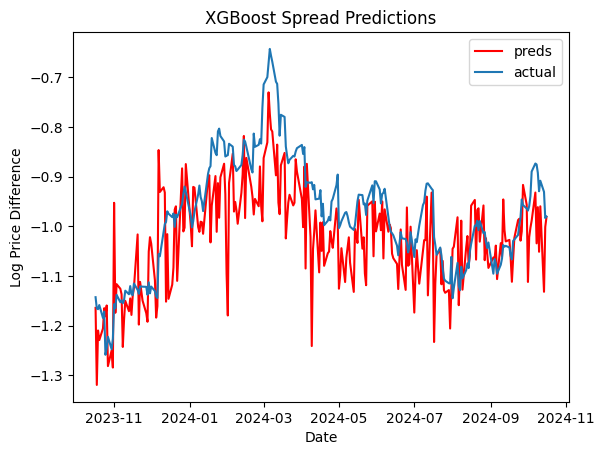

In [65]:
xgb.fit(x_train, y_train)

y_preds = xgb.predict(x_test)

print(f'RMSE: {root_mean_squared_error(y_preds, y_test)}')

plt.title('XGBoost Spread Predictions')
plt.xlabel('Date')
plt.ylabel('Log Price Difference')

plt.plot(y_test.index, y_preds, label='preds', color='red')
plt.plot(y_test.index, y_test, label='actual')

plt.legend()
plt.show()

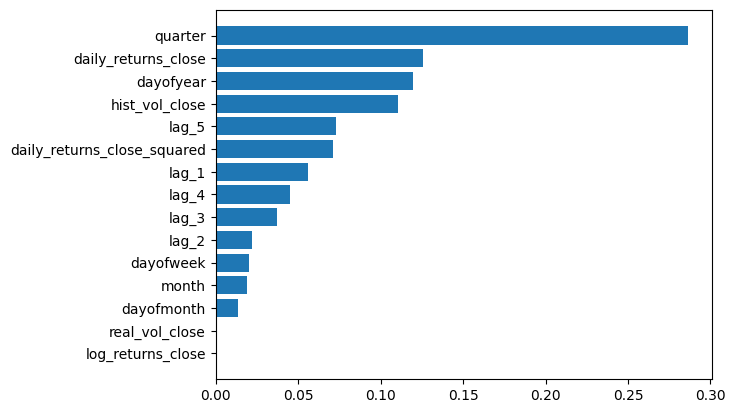

In [67]:
_ = trainer.plot_importance(xgb)

In [68]:
mse = make_scorer(root_mean_squared_error)

train_sizes, train_scores, test_scores = learning_curve(estimator=xgb, X=x_train, y=y_train, scoring=mse)

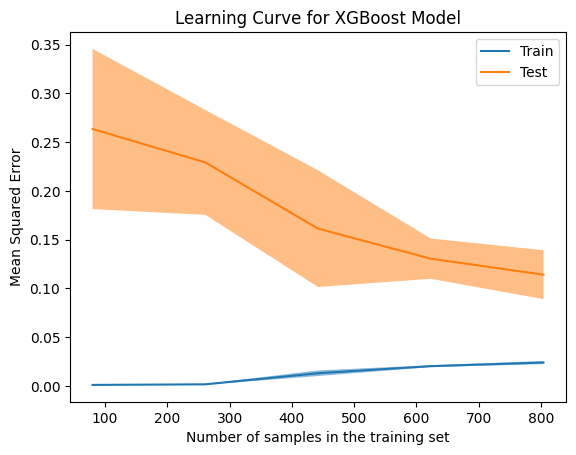

In [69]:
lc_display = LearningCurveDisplay(
    train_sizes=train_sizes, 
    train_scores=train_scores, 
    test_scores=test_scores, 
    score_name='Mean Squared Error'
)
lc_display.plot()
plt.title('Learning Curve for XGBoost Model')
plt.legend()
plt.show()

In [70]:
trader = AutoTrader(pair[0], pair[1], 10000)
xgb_results = trader.xgb_trade(y_preds, y_train, y_test)

Final Balance: $11679.56
Cumulative Return: 16.8%
Annualised Sharpe Ratio: 4.46


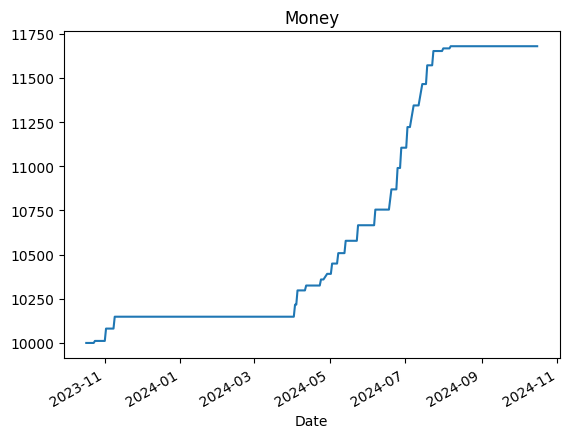

In [71]:
xgb_results['money'].plot()
plt.title('Money')
plt.show()

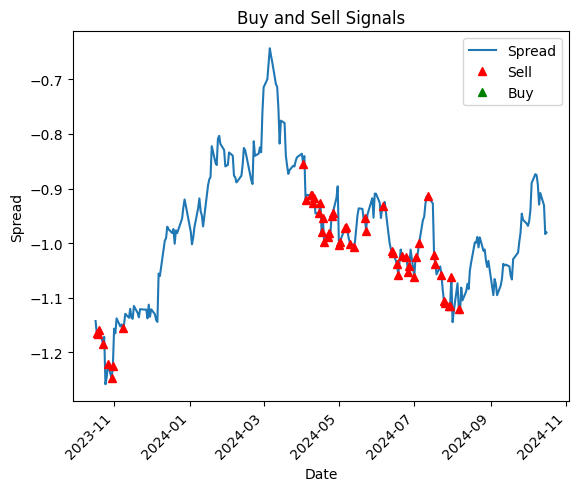

In [72]:
trader.plot_buy_sell(y_test, xgb_results)

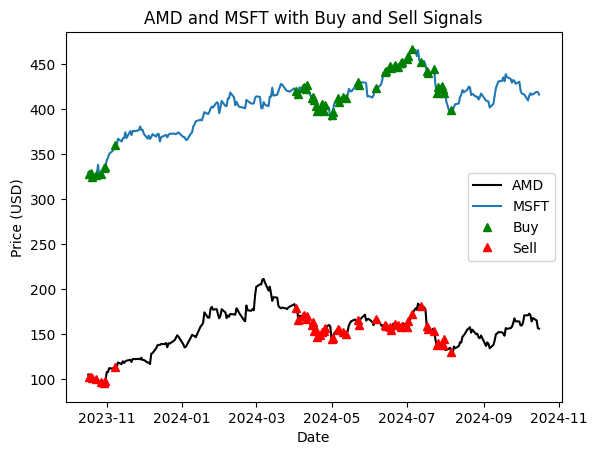

In [73]:
trader.plot_buy_sell_stock(xgb_results)

## **Tuning ARIMA Model**

In [9]:
warnings.filterwarnings(action='ignore')

param_space = {
    'p': [1,2,3,4],
    'q': [1,2,3,4],
    'd': [0, 1, 2]
}

arima_tuner = ARIMATuner()

best_params  = arima_tuner.grid_search(param_space, 'aic', spread_train)

AIC score = -4515.0870049752475, cfg = (1, 1, 0)
AIC score = -4513.056085682187, cfg = (1, 1, 1)
AIC score = -4511.079214277931, cfg = (1, 1, 2)
AIC score = -4090.61643185006, cfg = (1, 2, 0)
AIC score = -4500.742845991592, cfg = (1, 2, 1)
AIC score = -4498.658601954936, cfg = (1, 2, 2)
AIC score = -3269.479877024437, cfg = (1, 3, 0)
AIC score = -4075.810407129816, cfg = (1, 3, 1)
AIC score = -4476.783794112289, cfg = (1, 3, 2)
AIC score = -2294.2143551337026, cfg = (1, 4, 0)
AIC score = -3255.0318691923376, cfg = (1, 4, 1)
AIC score = -3766.555717080625, cfg = (1, 4, 2)
AIC score = -4513.159087012256, cfg = (2, 1, 0)
AIC score = -4511.155615877541, cfg = (2, 1, 1)
AIC score = -4509.597556298182, cfg = (2, 1, 2)
AIC score = -4223.988755150331, cfg = (2, 2, 0)
AIC score = -4498.777591937251, cfg = (2, 2, 1)
AIC score = -4496.844722610067, cfg = (2, 2, 2)
AIC score = -3566.9201560062065, cfg = (2, 3, 0)
AIC score = -4208.338622187208, cfg = (2, 3, 1)
AIC score = -4119.493539816171, cfg =

In [10]:
print(best_params)

(1, 1, 0)


RMSE: 0.07808531977784124


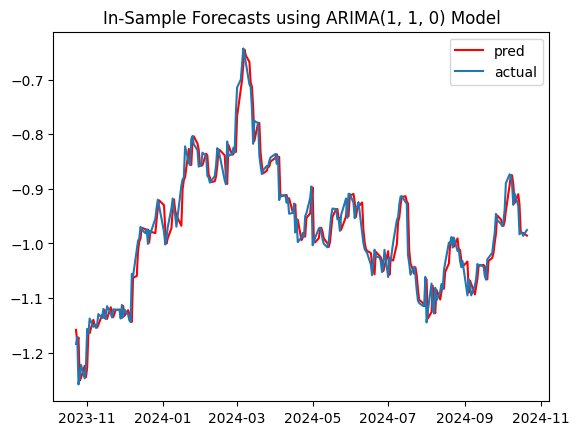

In [11]:
model = ARIMA(spread_test, order=best_params)

predictions = model.fit().predict()

print(f'RMSE: {root_mean_squared_error(predictions, spread_test)}')

plt.title('In-Sample Forecasts using ARIMA' + str(best_params) +' Model')

plt.plot(spread_test.index[1:], predictions[1:], label='pred', color='red')
plt.plot(spread_test.index[1:], spread_test[1:], label='actual')
plt.legend()
plt.show()

RMSE: 0.2216834386316375


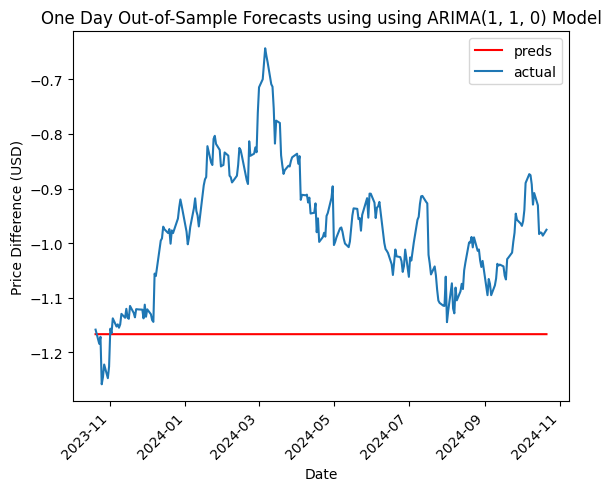

In [11]:
arima_trainer = ARIMATrainer()

preds = arima_trainer.walk_forward_eval(best_params, spread_train, spread_test)

plt.plot(spread_test.index, preds, label='preds', color='red')
plt.plot(spread_test.index, spread_test, label='actual')

plt.title('One Day Out-of-Sample Forecasts using using ARIMA' + str(best_params) + ' Model')
plt.xlabel('Date')
plt.ylabel('Price Difference (USD)')

plt.xticks(rotation=45, ha='right')
plt.legend()

plt.show()

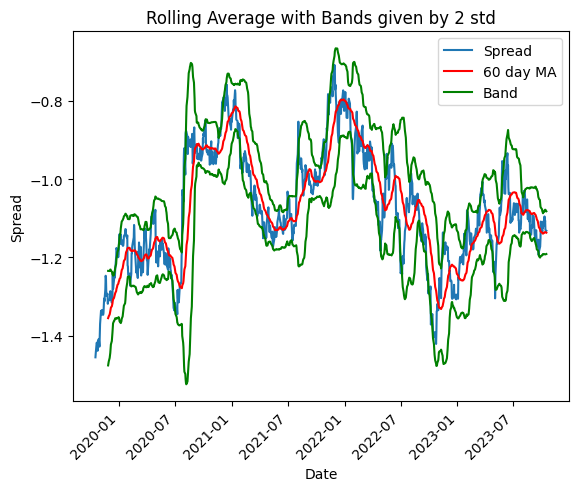

In [22]:
window = 30

train_spread_ma = spread_train.rolling(window=window).mean()
train_spread_std = spread_train.rolling(window=window).std()

upper_band = train_spread_ma + 2 * train_spread_std
lower_band = train_spread_ma - 2 * train_spread_std

plt.plot(spread_train.index, spread_train, label='Spread')

plt.plot(spread_train.index, train_spread_ma, label='60 day MA', color='red')
plt.plot(spread_train.index, upper_band, label='Band', color='green')
plt.plot(spread_train.index, lower_band, color='green')

plt.title('Rolling Average with Bands given by 2 std')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Date')
plt.ylabel('Spread')

plt.legend()
plt.show()

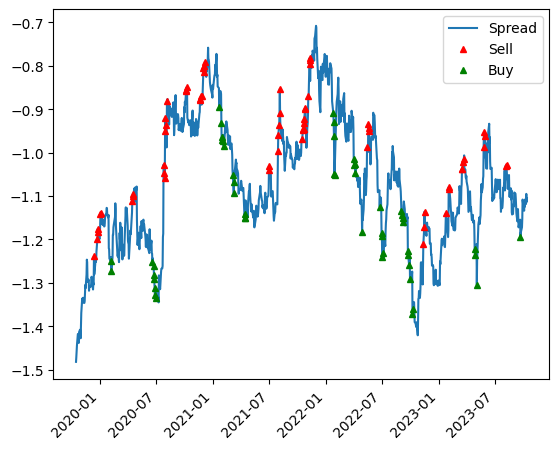

In [13]:
sell = pd.DataFrame(spread_train.copy(), index=spread_train.index)
buy = pd.DataFrame(spread_train.copy(), index=spread_train.index)

sell['sell'] = (spread_train.values >= upper_band.values)
buy['buy'] = (spread_train.values <= lower_band.values)

sell = sell[sell['sell'] == True]
buy = buy[buy['buy'] == True]

plt.plot(spread_train.index, spread_train, label='Spread')
plt.plot(sell.index, sell['Close'], color='r', linestyle='None', marker='^', label='Sell', markersize=5)
plt.plot(buy.index, buy['Close'], color='g', linestyle='None', marker='^', label='Buy', markersize=5)

plt.xticks(rotation=45, ha='right')

plt.legend()

plt.show()

## **Pairs Trading**

In [11]:
trader = AutoTrader(pair[0], pair[1], 10000)

results = trader.trade(best_params, spread_train, spread_test)

Final Balance: $11160.2
Cumulative Return: 11.6%
Annualised Sharpe Ratio: 3.12


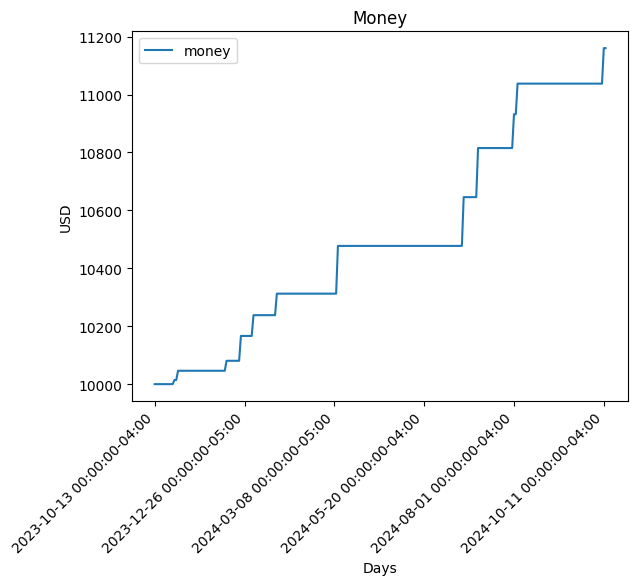

In [ ]:
results['money'].plot()

plt.xticks(rotation=45, ha='right')

plt.title('Money')
plt.xlabel('Days')
plt.ylabel('USD')

plt.legend()

plt.show()

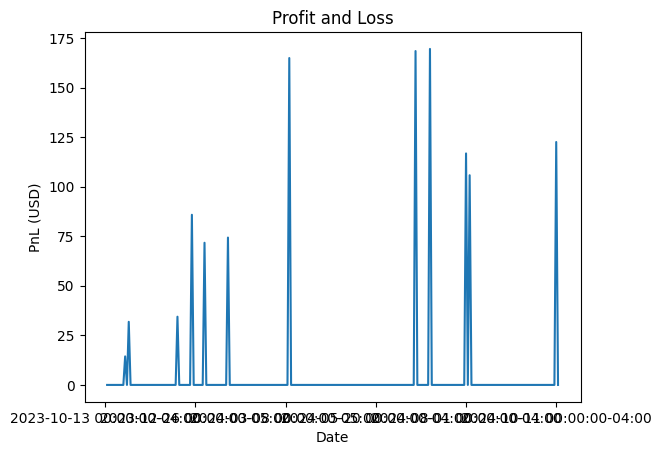

In [ ]:
results['PnL'].plot()
plt.title('Profit and Loss')
plt.xlabel('Date')
plt.ylabel('PnL (USD)')
plt.show()

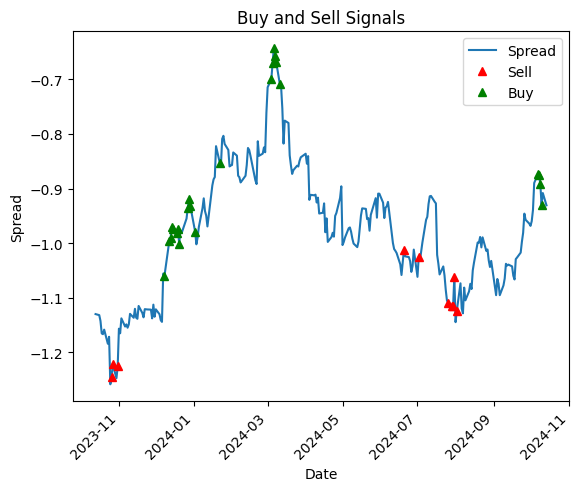

In [ ]:
trader.plot_buy_sell(spread_test, results)

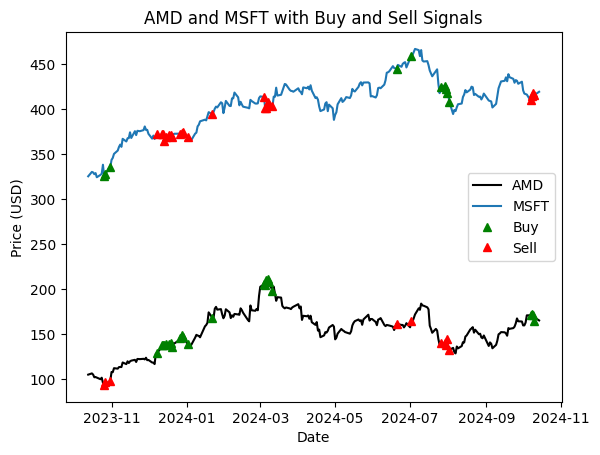

In [ ]:
trader.plot_buy_sell_stock(results)